## Growth Curves - Gompertz Equation

One form of the Gompertz (growth) equation is: $$W(t)=W_{m}e^{-e^{-k(t-T_{m})}}$$ where W<sub>m</sub> is the upper asymptote; k is the growth rate and T<sub>m</sub> the time at the inflexion point.

We will also be interested in _mu_, the maximum slope and _lambda_, the onset time of growth, also called the lag.

Since we are using experimental optical densities, we will also introduce a parameter, _A_ which represents the baseline optical density, to arrive at a modified equation: $$W(t)=A + (W_{m}-A)e^{-e^{-k(t-T_{m})}}$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dat = pd.read_excel('./growth_data.xlsx')
dat.head()

,time,OD
0,0,0.017176
1,14,0.019142
2,29,0.019937
3,44,0.019563
4,59,0.022208


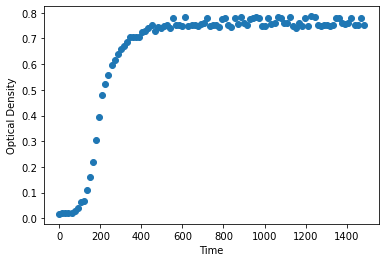

In [3]:
plt.scatter(dat.time,dat.OD);
plt.xlabel('Time')
plt.ylabel('Optical Density')
plt.show()

In [4]:
def gmpz(t,A,wm,k,tm):
  return A+(wm-A)*np.exp(-np.exp(-k*(t-tm)))

In [5]:
from scipy.optimize import curve_fit

 The *curve\_fit* function may become unstable, e.g. generating **NaN** or **Inf**, depending upon the equation and starting parameters. Convergence is better if we guess reasonable starting point for parameters, this is done using p0.

In [6]:
A = min(dat.OD)
Wm = max(dat.OD)
k = 0.1 # just guess!
Tm = np.median(dat.time)
p0 = [A,Wm,k,Tm]
p0

[0.01717597970829579, 0.7864616264748774, 0.1, 741.5]

In [7]:
params, covariance = curve_fit(gmpz,dat['time'],dat['OD'],p0=p0)
A = params[0]
Wm = params[1]
k = params[2]
Tm = params[3]
print(f'A: {A:0.3f} Wm: {Wm:0.3f} k: {k:0.3f} Tm: {Tm:0.3f}')

A: 0.019 Wm: 0.759 k: 0.017 Tm: 174.405


In [8]:
ypred = gmpz(dat.time,A,Wm,k,Tm)

In [9]:
from sklearn.metrics import r2_score

In [10]:
R2 = r2_score(dat.OD,ypred)
print(f'R2 Score: {R2:0.3f}')

R2 Score: 0.996


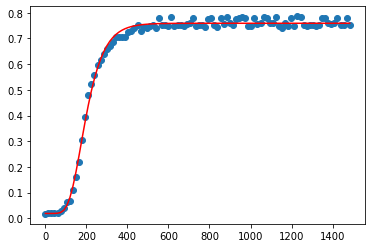

In [11]:
plt.plot(dat.time,ypred,color='red')
plt.scatter(dat.time,dat.OD)
plt.show()

Derived parameters:

In [12]:
mu = (Wm - A)*k/np.exp(1) #max slope
L = (Tm*k-1)/k # lambda
print(f'lambda = {L:0.3f} mu = {mu:0.3f}')

lambda = 113.963 mu = 0.005


In [13]:
Lc = A - L*mu
Ly = mu*Tm + Lc
print(f'Lc = {Lc:0.3f} Ly = {Ly:0.3f}')

Lc = -0.494 Ly = 0.291


In [14]:
abline = [x*mu + Lc for x in dat.time]

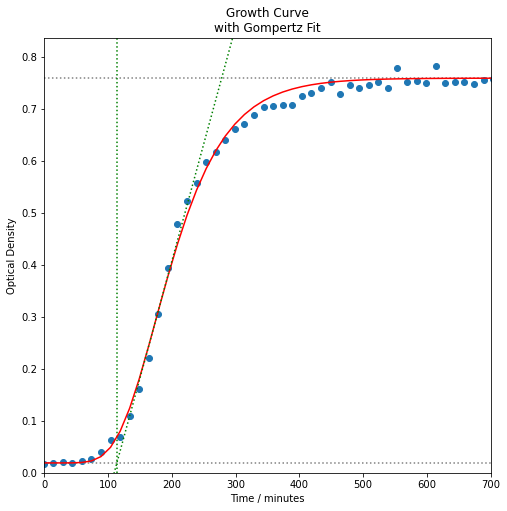

In [15]:
plt.figure(figsize=(8,8))

plt.plot(dat.time,ypred,color='red')
plt.scatter(dat.time,dat.OD)
plt.xlim(0,700)
plt.ylim(0,max(dat.OD)+0.05)
plt.hlines([Wm,A],0,700,color='gray',linestyles='dotted')
plt.vlines(L,0,max(dat.OD)+0.05,color='green',linestyles='dotted')
plt.plot(dat.time,abline,color='green',linestyle='dotted')
plt.xlabel('Time / minutes')
plt.ylabel('Optical Density')
plt.title('Growth Curve\nwith Gompertz Fit')
plt.show()

Notice that here we have defined _lambda_ to be where the tangent to maximum growth rate crosses the base line. Other definitions are possible, for example based on reaching some small fraction of maximum growth. 

## The Bootstrap: Finding Parameter confidence Intervals
To be continued...